## Generate Training Data for DeepCormack: PCA + DMD

#### Required:
- A DFT calculated 3D electron momentum density (copper in our case)

- Output:

In [1]:
# Create conda environment for MCM first. In the terminal, run:
# conda env create -f environment.yml
from MCM_functions_new import *

In [2]:
"""Defining Modified Cormack Method Parameters"""

N = 513                                                                     # image size (N x N pixels) of copper projections                                    
raw_proj_dir = "Data_Generation_Required/Cu_20Projections(513)"             # directory containing ideal copper projections

pang = np.linspace(0, 45, 20)                                               # projection angles for the 20 projections for the DFT copper data        
ncoeffs = [150, 120, 100, 90, 80, 50]                                       # number of Chebyshev coefficients for each projection angle      
ncoeffs.extend([30]* (20-len(ncoeffs)))

order = 4                                                                   # copper's FCC structure means it has 4-fold symmetry (order = 4)                                  
nphi = 180                                                                  # angle increments for delta in polar unit circle are given by 90/nphi; 'm_max = nphi' when computing Chebyshev coefficients      
# calib = 0.09808                                                             # Experimental data calibration factor (pixels per mm) for copper data — NOT USED                           
xsize = N // 2                                                              # Centre of the image in pixels
rhocut = 1                                                                  # 1 = don't cut off, 0 = cut off at flvl 
flvl = 100                                                                  # Choose Fermi level so the cutoff starts at your desired px (e.g., 256) (max value is N/2 = 256 for N=513)
kt = 6.0                                                                    # Slope; increase for smoother, decrease for sharper
rhofn = [rhocut, flvl, kt]
rhofn_PCA = [0, 200, 6.0]

# Generating Experimental Data.
num_simulations = 1                                                         # Number of simulated 3D TPMD datasets to generate                               
count_ttl = 200_000_000                                                     # What should the simulated total counts be? ≈200,000,000 corresponds to 3 months of measurements!

base_dir = "Data_Generation_Required/TPMD_Data"
rho_real_dir = os.path.join(base_dir, "Rho_Measurement")
os.makedirs(rho_real_dir, exist_ok=True)

rho_ideal_dir = os.path.join(base_dir, "Rho_GroundTruth")
os.makedirs(rho_ideal_dir, exist_ok=True)


In [3]:
"""Defining Training Data Parameters"""
n_samples = 500                                                             # Number of 3D TPMD samples to generate                                      
sigma = 2                                                                   # Recommended convolution sigma for Gaussian kernel (in pixels) on synthetic rho_n to improve TPMD quality

#### Copper 3D TPMD – PCA sampling of Chebyshev coefficients

In [4]:
""" --- Copper 3D TPMD ---

Calculate a_n^m and rho_n for the ideal DFT copper projections. PCA per channel 'n' will be used on copper a_n^m 
coefficients all 256 slices combined. Randomly sampling from each of the 'n' the latent spaces will generate new, 
realistic a_n^m coefficients, giving us a consistent way to create new, realistic rho_n for TPMD central slices.

    Parameters
    ----------
    raw_projs : shape (N, N, nproj) = (513, 513, 20)
    anm_Cu : shape (xsize, nphi, nproj) = (256, 180, 20)
    rhoreturn_ideal_Cu : shape (xsize, nphi, xsize) = (256, 20, 256). 
                            The final index denotes the rho_n slices.
"""

# Fetching the ideal copper projections
file_names = [f"I_TPMD2D.OUT_PROJ_{i+1}" for i in range(20)]
raw_projs = load_projections(raw_proj_dir, file_names, N)                   # shape (N, N, 20)
rhoreturn_ideal_Cu, anm_Cu = getrho(raw_projs, order, pang, nphi, 20 * [120], rhofn)


In [5]:
# Standardize the anm matrix so that for each j and i, anm[j][:, i] has mean 0 and std 1.
anm_pca, means_orig, stds_orig = standardize_anm(anm_Cu)                    # means_orig, stds_orig store the original means and stds for each (j, i) to unstandardize later
how_much_var = 58                                                           # e.g., dim=24 gives 95% of variance, dim=34 gives 99%, and dim=58 gives 99.97%.

n_components = how_much_var                                                 # PCA latent space dimensions
latent_spaces = []                                                          # store latent coordinates (256 × n_components)
pca_models = []                                                             # store PCA models
latent_means = []
latent_covs = []

for k in range(anm_pca.shape[2]):  # iterate over 20 functions
    X = anm_pca[:, :, k]  # shape (256, 180)

    # Center the data (important!)
    X_centered = X - X.mean(axis=0, keepdims=True)

    # Fit PCA across slices
    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(X_centered)                                       # shape (256, n_components)

    latent_spaces.append(Z)
    pca_models.append(pca)
    latent_means.append(Z.mean(axis=0))
    latent_covs.append(np.cov(Z, rowvar=False))

In [23]:
mean_Z = latent_spaces[k].mean(axis=0)
cov_Z = np.cov(latent_spaces[k], rowvar=False)

# Sample new latent coordinates
Z_new = np.random.multivariate_normal(mean_Z, cov_Z, size=20)  # e.g., 20 new slices

# Reconstruct new coefficients
X_new = pca_models[k].inverse_transform(Z_new)

In [24]:
print(anm_pca.shape[0])

256


In [25]:
# Sampling new synthetic a_n^m coefficients for all 'n = 20' a_n^m channels/functions
# anm_pca_synthetic = np.zeros_like(anm_pca)
anm_pca_synthetic = np.zeros((n_samples, anm_pca.shape[1], anm_pca.shape[2]))           # (n_samples, 180, 20), because we want to create 'n_samples' number of central slices for our training data

for k in range(anm_pca.shape[2]):  # for each function
    mean_Z = latent_means[k]
    cov_Z = latent_covs[k]
    pca = pca_models[k]

    # Sample new latent coordinates for 256 slices
    Z_new = np.random.multivariate_normal(mean_Z, cov_Z, size=n_samples)                # (256, n_components)

    # Optional: smooth slightly along slices for realistic variation
    # from scipy.ndimage import gaussian_filter1d
    # Z_new_smooth = gaussian_filter1d(Z_new, sigma=1, axis=0)

    # Reconstruct new coefficients
    X_new = pca.inverse_transform(Z_new)
    
    # Add back the original mean (since PCA used centered data)
    X_new += anm_pca[:, :, k].mean(axis=0, keepdims=True)

    anm_pca_synthetic[:, :, k] = X_new

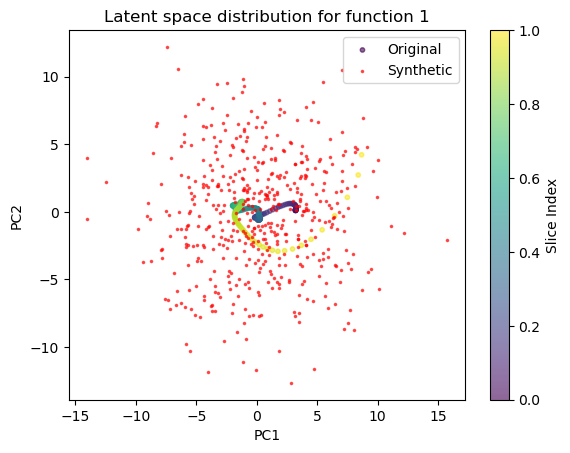

(256, 58)


In [26]:
visualize_function = 0
Z_orig = pca_models[visualize_function].transform(anm_pca[:, :, visualize_function] - anm_pca[:, :, visualize_function].mean(axis=0))
zoot = 0
plt.scatter(Z_orig[:, zoot], Z_orig[:, zoot+1], s=10, label='Original', alpha=0.6, c=np.arange(anm_pca.shape[0]), cmap='viridis')
plt.scatter(Z_new[:, zoot], Z_new[:, 1], s=10, label='Synthetic', alpha=0.6, marker='.',color='red')
plt.legend()
plt.colorbar(label='Slice Index', orientation='vertical', location='right')
plt.title(f"Latent space distribution for function {visualize_function+1}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
print(Z_orig.shape)

In [51]:
anm_synth, _, _ = standardize_anm(anm_pca_synthetic)
anm_synth = unstandardize_anm(anm_synth, means_orig, stds_orig)

anm_copper_normalized = unstandardize_anm(anm_Cu, means_orig, stds_orig)
copper_getrho_normalized = getrho_anm_synth(order, ncoeffs, rhofn_PCA, anm_Cu, xsize)       # So that when we sample rho_0 from copper, it's consistent with the required central slice maxima


# rhoreturn_synth = getrho_anm_synth(raw_projs, order, pang, nphi, ncoeffs, rhofn_PCA, anm_synth)
rhoreturn_synth = getrho_anm_synth(order, ncoeffs, rhofn_PCA, anm_synth, xsize)
rhoreturn_synth_norm, max_vals_synth = normalize_rhoreturn_ideal_Cu(rhoreturn_synth)

In [52]:
print(rhoreturn_synth.shape)  # (n_samples, 180, 256)

(256, 20, 500)


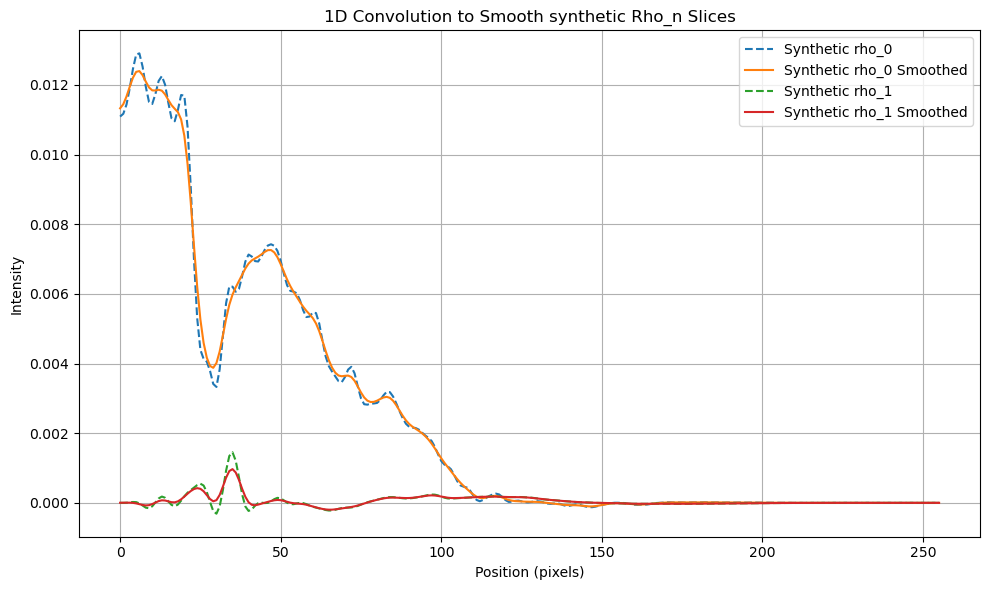

In [67]:
sigma = 2  # Adjust smoothing as needed
slice_idx = 1

plt.figure(figsize=(10, 6))
for i in range(0, 2):  # i from 0 to 20 inclusive
    smoothed = gaussian_filter1d(rhoreturn_synth[:, i, slice_idx], sigma=2)
    plt.plot(rhoreturn_synth[:, i, slice_idx], linestyle='--', label=f"Synthetic rho_{i}")
    plt.plot(smoothed,label=f"Synthetic rho_{i} Smoothed")

plt.title('1D Convolution to Smooth synthetic Rho_n Slices')
plt.xlabel('Position (pixels)')
plt.ylabel('Intensity')
plt.legend()
# plt.xlim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
def adjust_rho0_maxima(normalize_rhoreturn_ideal, rhoreturn_ideal_Cu, percent=0.10, rng=None,
                                    rhocut=1, kt=6.0):
    """
    For each idx and each i in 0..N, rescales normalize_rhoreturn_ideal[:, i, idx] so its maximum is a random value
    within ±percent of the absolute maximum of rhoreturn_ideal_Cu[:, i, 0], then applies rhocutoff.
    For i=0, uses flvl=100; for all other i, uses flvl=35.
    """
    if rng is None:
        rng = np.random.default_rng()
    adjusted = np.copy(normalize_rhoreturn_ideal)
    xsize = normalize_rhoreturn_ideal.shape[0]
    n_i = normalize_rhoreturn_ideal.shape[1]
    n_idx = normalize_rhoreturn_ideal.shape[2]
    for idx in range(n_idx):
        for i in range(n_i):
            target_max = np.max(np.abs(rhoreturn_ideal_Cu[:, i, 0]))
            if i == 0:
                upper = target_max * (1 + 0.05)
                lower = target_max * (1 - 0.05)
            else:
                lower = target_max * (1 - percent/2)
                upper = target_max * (1 + percent)
            new_max = rng.uniform(lower, upper)
            current_max = np.max(np.abs(normalize_rhoreturn_ideal[:, i, idx]))
            flvl_val = 128 if i == 0 else 100
            cutoff = rhocutoff(xsize, rhocut, flvl_val, kt)
            if current_max != 0:
                adjusted[:, i, idx] = normalize_rhoreturn_ideal[:, i, idx] * (new_max / current_max) * cutoff
            else:
                adjusted[:, i, idx] = 0
    return adjusted

In [78]:
### Including a condition that the chosen Rho_0 is not smaller than the absolute max value of any of the other rhos (otherwise negative values may appear in the TPMD)

# List to collect only successful candidates
successful_slices = []

sigma = 3  # Adjust as needed

for idx in range(rhoreturn_synth_norm.shape[2]):
    # Smooth all slices for this idx
    smoothed = np.empty_like(rhoreturn_synth_norm[:, :, idx])
    for i in range(rhoreturn_synth_norm.shape[1]):
        smoothed[:, i] = gaussian_filter1d(rhoreturn_synth_norm[:, i, idx], sigma=sigma)

    success = False
    for attempt in range(3):
        rand_val = custom_randint()
        # cu_slice = rhoreturn_ideal_Cu[:, 0, rand_val]
        cu_slice = copper_getrho_normalized[:, 0, rand_val]
        target_max = smoothed[:, 0].max()
        if cu_slice.max() == 0:
            continue

        summed = np.sum(smoothed, axis=1)

        # If rand_val is in 60..116, rescale candidate to the largest possible value so that candidate + summed >= -0.1*target_max everywhere
        if 60 <= rand_val <= 133:
            mask_pos = cu_slice > 0
            mask_neg = cu_slice < 0

            scale_min = -np.inf
            if np.any(mask_pos):
                scale_min = np.max((-0.005 * target_max - summed[mask_pos]) / cu_slice[mask_pos])
            scale_max = np.inf
            if np.any(mask_neg):
                scale_max = np.min((-0.005 * target_max - summed[mask_neg]) / cu_slice[mask_neg])

            orig_scale = target_max / cu_slice.max()
            final_scale = min(orig_scale, scale_max)
            if final_scale < scale_min or final_scale <= 0:
                continue
            candidate = cu_slice * final_scale
        else:
            # Use original scaling
            scale = target_max / cu_slice.max()
            candidate = cu_slice * scale

            # Check the condition
            if np.all(candidate + summed >= -0.1 * target_max):
                smoothed[:, 0] = candidate
                successful_slices.append(smoothed)
                success = True
                break
    # If not successful after 3 attempts, skip this idx

# Stack only successful slices
if successful_slices:
    rhoreturn_ideal_smoothed2 = np.stack(successful_slices, axis=2)
    print("Created rhoreturn_ideal_smoothed2 with shape:", rhoreturn_ideal_smoothed2.shape)
    print("Number of successful candidates:", rhoreturn_ideal_smoothed2.shape[2])
else:
    print("No successful candidates found.")



Created rhoreturn_ideal_smoothed2 with shape: (256, 20, 343)
Number of successful candidates: 343


In [82]:
rhoreturn_ideal_smoothed_central = adjust_rho0_maxima(rhoreturn_ideal_smoothed2, rhoreturn_ideal_Cu, percent=0.0025)

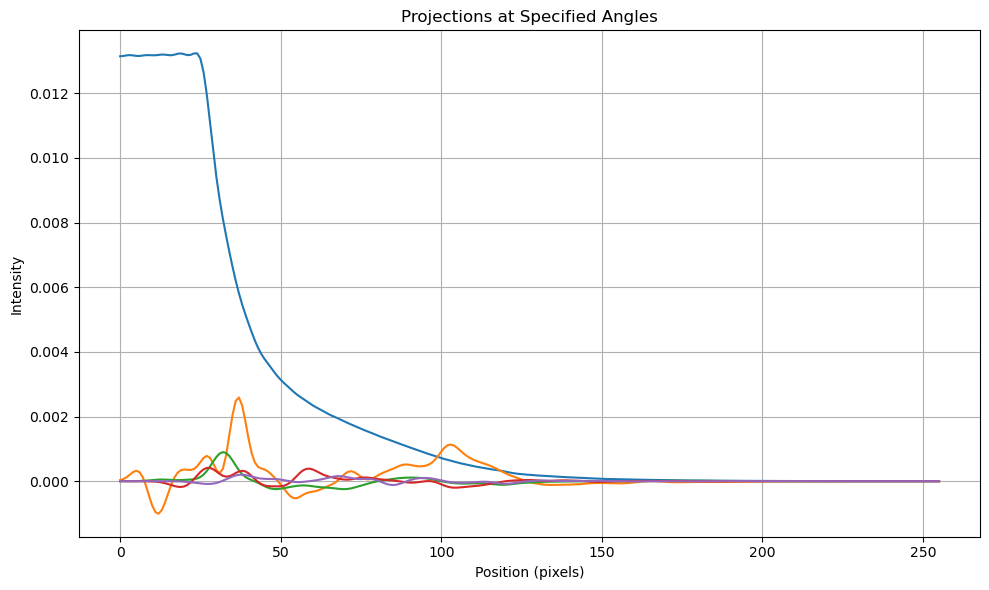

In [70]:
# Plot the projections

idx = 0
plt.figure(figsize=(10, 6))
for i in range(0,5):
    # plt.plot(rhoreturn_ideal_smoothed2[:, i, idx])
    plt.plot(rhoreturn_ideal_smoothed_central[:, i, idx])

plt.title('Projections at Specified Angles')
plt.xlabel('Position (pixels)')
plt.ylabel('Intensity')
# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
Synthetic_Central_Slices = calcplane(rhoreturn_ideal_smoothed2, rhoreturn_ideal_smoothed2.shape[2], order)
animate_slices_normalized(Synthetic_Central_Slices, start_frame=0, end_frame=25, save_mp4=False)


In [83]:
Synthetic_Central_Slices_rho0_adjusted = calcplane(rhoreturn_ideal_smoothed_central, rhoreturn_ideal_smoothed_central.shape[2], order)
animate_slices_normalized(Synthetic_Central_Slices_rho0_adjusted, start_frame=0, end_frame=25, save_mp4=False)


In [ ]:
model = train_pca_dmd_per_channel(anm_Cu, latent_dim=38)
predicted = rollout_per_channel(model, anm_arr[0], n_steps=256)
rhos_evolved = anm_to_rhos(predicted, order, rhofn, ncoeffs)

print(predicted.shape)
print(rhos_evolved.shape)

Rand_vol_evolved = calcplane(rhos_evolved, rhos_evolved.shape[2], order)
# animate_slices_normalized(Rand_vol_evolved, start_frame=0, end_frame=Rand_vol_evolved.shape[1]-1, save_mp4=False)
# animate_slices_normalized(Rand_vol_evolved, start_frame=0, end_frame=Rand_vol_evolved.shape[1]-1, save_mp4=True)
animate_slices_normalized(Rand_vol_evolved, start_frame=0, end_frame=100, save_mp4=False)